## _Track Evaluation_

- Running _`trkx_from_gnn.py`_ produces recostucted tracks (track candiates)
- Running _`trkx_reco_eval.py`_ gives reconstruction evaluation: _`eff, fake rate, dup. rate, etc`_

Let's perform inspection after track evaluation.

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# local imports
from src import draw_proc_event, cylindrical_to_cartesian

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

___
## _Inspection of Epsilon in DBSCAN_

1. Various $\epsilon$ for DBSCAN in `trkx_from_gnn.py`
2. Choose the best $\epsilon$ based on _`eff, fake rate, dup. rate`) after `trkx_reco_eval.py`

**NOTE:** The $\epsilon$ in DBSCAN is alternative to chosing a cut on the `edge_score`.

In [7]:
# lists from eval_summary.txt
e_list = [0.10, 0.15, 0.20, 0.25, 0.35, 0.45, 0.55, 0.75, 0.85, 0.95]
eff_list = [90.86,91.68,91.68,91.58,89.84,87.58,85.83,83.57,81.52,76.28]

In [8]:
# covert to ndarrays
eff = np.array(eff_list)
epsilon = np.array(e_list)

In [9]:
len(e_list)==len(eff_list)

True

In [10]:
for i in range(len(e_list)):
    print("epsilon: ", e_list[i])

epsilon:  0.1
epsilon:  0.15
epsilon:  0.2
epsilon:  0.25
epsilon:  0.35
epsilon:  0.45
epsilon:  0.55
epsilon:  0.75
epsilon:  0.85
epsilon:  0.95


In [11]:
#plt.style.use('ggplot')
#mpl.rcParams.update(mpl.rcParamsDefault)

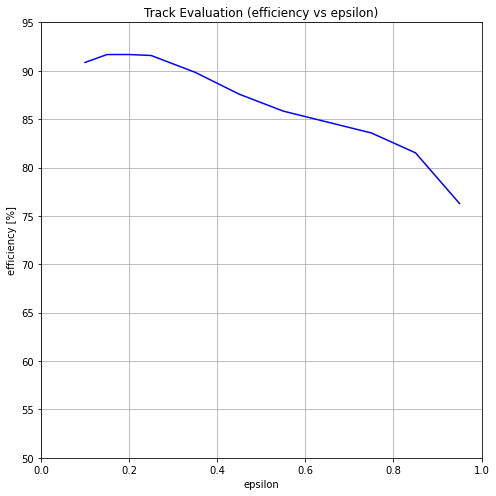

In [12]:
# init subplots
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.plot(epsilon, eff, linestyle='-', linewidth=1.5, color='blue')

# plotting params
ax.set_title('Track Evaluation (efficiency vs epsilon)')
ax.set_xlabel('epsilon', fontsize=10)
ax.set_ylabel('efficiency [%]', fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(50, 95)
ax.grid(True)
#ax.legend(fontsize=10, loc='best')
fig.tight_layout()
#fig.savefig("epsilon_eff.png")

## _Visualize Test Data_

Inspect easy to difficult to reconstruct tracks. Choose 10 such events and use `score_cut=0.25`

In [13]:
inputdir="run/feature_store/test"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [14]:
feature_data = torch.load(proc_files[1], map_location=device)

In [15]:
feature_data

Data(x=[152, 3], pid=[152], layers=[152], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_all/event0000009001', hid=[152], pt=[152], modulewise_true_edges=[2, 141], layerwise_true_edges=[2, 147], edge_index=[2, 691], y_pid=[691])

In [16]:
event_id = int(os.path.basename(feature_data.event_file)[-10:])

In [17]:
mpl.rcParams.update(mpl.rcParamsDefault)

## _Inspection on Track Duplication_

- Let's look into track candidates
- Draw reco tracks match with true tracks
- Draw duplicated reco tracks

### _(1)-Read Test Events_

In [18]:
inputdir="run/feature_store/test"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [19]:
proc_files[:5]

['run/feature_store/test/9000',
 'run/feature_store/test/9001',
 'run/feature_store/test/9002',
 'run/feature_store/test/9003',
 'run/feature_store/test/9004']

In [20]:
# event Data
feature_data = torch.load(proc_files[1], map_location=device)
print("Length of Data: {}".format(len(feature_data)))

Length of Data: 10


In [21]:
feature_data

Data(x=[152, 3], pid=[152], layers=[152], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_all/event0000009001', hid=[152], pt=[152], modulewise_true_edges=[2, 141], layerwise_true_edges=[2, 147], edge_index=[2, 691], y_pid=[691])

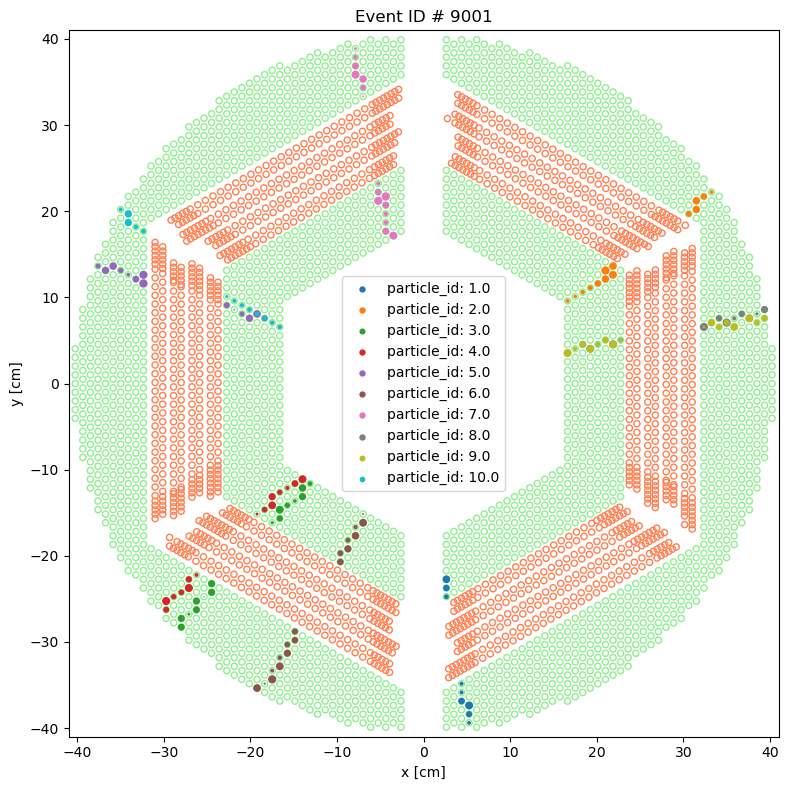

In [22]:
# draw a processed event
draw_proc_event(feature_data, figsize=(8,8), save_fig=False);

### _(2)-Read Track Candidate_

In [23]:
inputdir="run/trkx_from_gnn"
trkx_from_gnn = sorted(glob.glob(os.path.join(inputdir, "*")))

In [24]:
trkx_from_gnn[:5]

['run/trkx_from_gnn/900',
 'run/trkx_from_gnn/901',
 'run/trkx_from_gnn/902',
 'run/trkx_from_gnn/903',
 'run/trkx_from_gnn/904']

In [25]:
reco_tracks = torch.load(trkx_from_gnn[1], map_location=device)

In [26]:
reco_tracks.head()

,hit_id,track_id
0,1,-1
1,123,-1
2,150,0
3,175,-1
4,200,-1


### _(3)-Read Track Evaluation Data_

In [27]:
# path to HDF5 Store
hdf5_path = 'run/trkx_reco_eval/eval_particles.h5'

In [28]:
df = pd.read_hdf(hdf5_path)

In [29]:
df.head()

,particle_id,pt,n_true_hits,is_matched,is_trackable,evtid
0,6,0.461538,18,True,True,900
1,9,0.073745,15,True,True,900
2,8,0.510547,17,True,True,900
3,4,0.712900,17,True,True,900
4,2,0.650417,18,True,True,900


### _(4)-Plot Reco Tracks_

- lets plot two reconstructed events, one is `good` and the other a little `bad`
- see an event with duplicated tracks, find out why they are duplicated.

In [30]:
reco_tracks_1 = torch.load(trkx_from_gnn[96], map_location=device)
reco_tracks_2 = torch.load(trkx_from_gnn[98], map_location=device)

In [39]:
reco_tracks_1.head()

,hit_id,track_id
0,100,0
1,51,1
2,126,2
3,1,3
4,151,4


In [32]:
reco_tracks_2.head()

,hit_id,track_id
0,122,-1
1,123,-1
2,152,-1
3,26,0
4,73,1


In [33]:
reco_tracks = reco_tracks_1

pid:  0
pid:  1
pid:  2
pid:  3
pid:  4
pid:  5
pid:  6
pid:  7
pid:  8
pid:  9


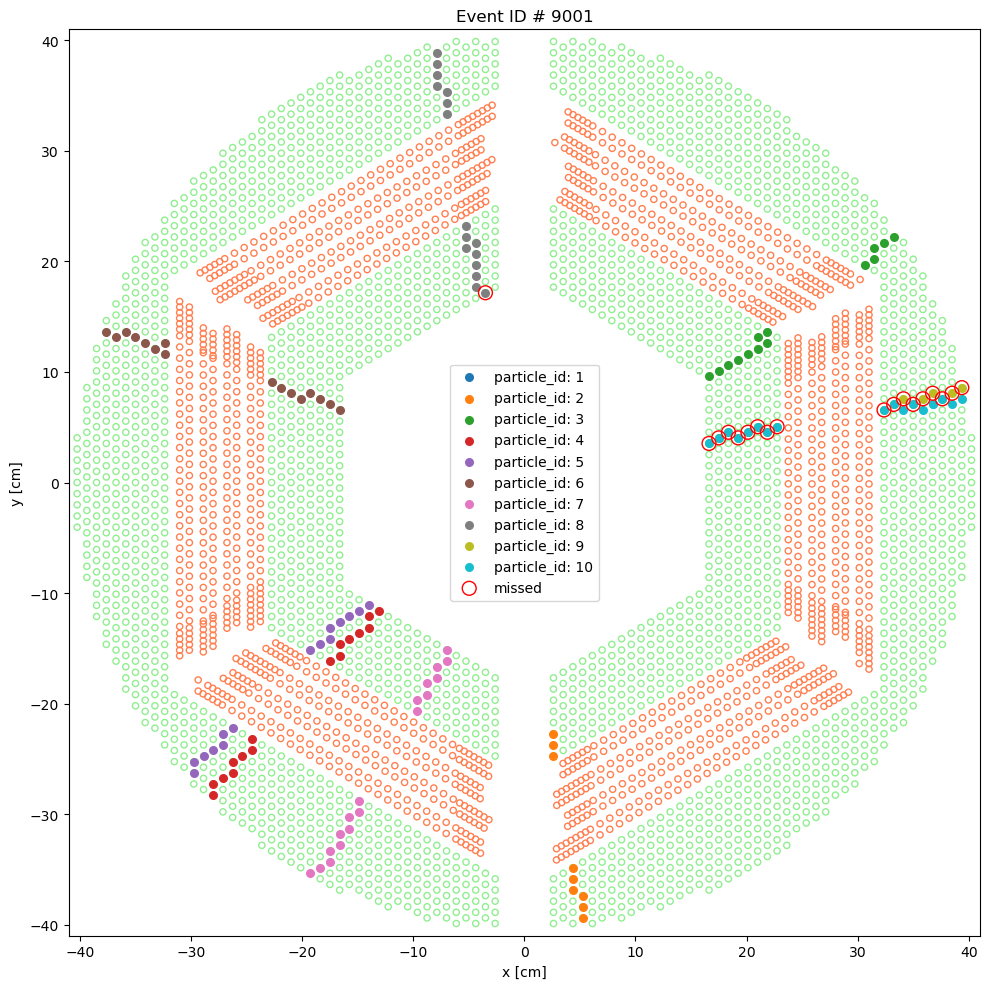

In [40]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
ax.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
ax.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# feature data
x,y,_ = cylindrical_to_cartesian(r=feature_data.x[:, 0],
                                 phi=feature_data.x[:, 1],
                                 z=feature_data.x[:, 2])

# reco track(s)
pids = np.unique(reco_tracks.track_id)
for pid in pids:
    print("pid: ", pid)
    idx = feature_data.pid == (pid)
    if pid >= 0:
        ax.scatter(x[idx], y[idx], s=30, label='particle_id: %d' %(pid+1))

# Missed hits
missed_hids= reco_tracks.query("track_id==1")["hit_id"].values
hids = feature_data.hid.numpy()
idx = np.where(np.isin(hids, missed_hids))[0]
ax.scatter(x[idx], y[idx], facecolors='none', edgecolors='red', s=100, linewidth=1, label='missed')

# plotting params
ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]', fontsize=10)
ax.set_ylabel('y [cm]', fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")

In [35]:
np.unique(reco_tracks.track_id.values)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
missed_hid = reco_tracks.query("track_id==-1")["hit_id"]
missed_hids = missed_hid.values

In [37]:
missed_hids

array([], dtype=int32)

In [38]:
gnn_eval_data.hid

NameError: name 'gnn_eval_data' is not defined

In [ ]:
hids = gnn_eval_data.hid.numpy()

In [ ]:
# let get indices of missed_hids in hids
idx = np.where(np.isin(hids, missed_hids))[0]